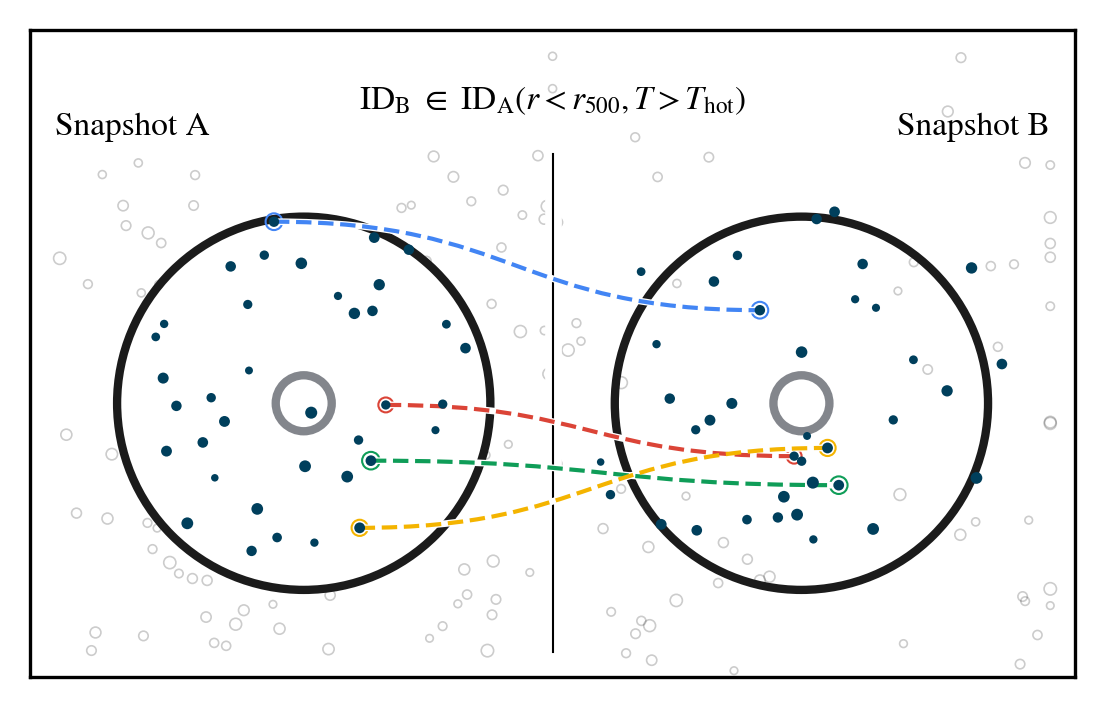

In [301]:
"""
https://stackoverflow.com/questions/63560005/draw-curved-lines-to-connect-points-in-matplotlib
"""
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.path import Path
from matplotlib import patches
from itertools import cycle, islice 

def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

np.random.seed(345)

plt.style.use("mnras.mplstyle")
colors = ['#DB4437', '#4285F4', '#0F9D58', '#F4B400']
selection_color = '#003f5c'
r500 = 1.5

fig, ax = plt.subplots(figsize=(3.5, 3.5 / (2.2 + 6.2) * (2.2 + 3)), constrained_layout=True)
fig.set_facecolor('w')
ax.set_facecolor('w')
ax.set_aspect('equal')

ax.text(-2, 2.1,'Snapshot A', ha='left', va='bottom')
ax.text(6, 2.1,'Snapshot B', ha='right', va='bottom')
ax.text(2, 2.3, r'ID$_{\rm{B}}~\in~$ID$_{\rm{A}}(r<r_{500}, T > T_{\rm{hot}})$', ha='center', va='bottom')

ax.plot([2, 2], [-2, 2], color='w', ls='-', lw=4, zorder=1)
ax.plot([2, 2], [-2, 2], color='k', ls='-', lw=0.5, zorder=2)


# Field gas particles (left)
n = 100
circle_list = []
while len(circle_list) < n:
    r = np.random.uniform(0.03, 0.05)
    x = np.random.uniform(-2, 2)
    y = np.random.uniform(-2, 2)
    
    collide = False
    for x2, y2, r2 in circle_list:
        d = euclidean_distance(x, y, x2, y2)
        if d < r + r2:
            collide = True
            break
    
    if not collide:
        circle_list.append((x, y, r))

for x, y, r in circle_list:

    if euclidean_distance(x, y, 0, 0) < r500:
        circle = patches.Circle((x, y), r, facecolor=selection_color, edgecolor='none', zorder=10)
    else:
        circle = patches.Circle((x, y), r, facecolor='none', edgecolor='k', alpha=0.2, linewidth=0.4, zorder=0)
    
    ax.add_patch(circle)

coords_a = np.asarray(circle_list)[:, :-1]
mask_r500 = np.where(np.sqrt(coords_a.T[0] ** 2 + coords_a.T[1] ** 2) < r500)[0]

# Field gas particles (right)
jitter = 0.5
circle_list_b = []
for pid, (x, y, r) in enumerate(circle_list):
    r_b = r
    x_b = x + np.random.normal(0, jitter) + 4
    y_b = y + np.random.normal(0, jitter)
    
    x_b = np.clip(x_b, 2, 6)
    circle_list_b.append((x_b, y_b, r_b))

    if pid in mask_r500:
        circle = patches.Circle((x_b, y_b), r_b, facecolor=selection_color, edgecolor='none', zorder=10)
    else:
        circle = patches.Circle((x_b, y_b), r_b, facecolor='none', edgecolor='k', alpha=0.2, linewidth=0.4, zorder=0)
        
    ax.add_patch(circle)

patch_collection = [
    patches.Circle((0, 0), radius=r500, facecolor='none', lw=2, edgecolor='#1b1b1b'),
    patches.Circle((4, 0), radius=r500, facecolor='none', lw=2, edgecolor='#1b1b1b'),
    patches.Circle((0, 0), radius=0.15 * r500, facecolor='none', lw=2, edgecolor='#4F535C', alpha=0.7),
    patches.Circle((4, 0), radius=0.15 * r500, facecolor='none', lw=2, edgecolor='#4F535C', alpha=0.7)
]
for patch in patch_collection:
    ax.add_patch(patch)

    
# Select particles
coords_a = np.asarray(circle_list)[:, :-1]
coords_b = np.asarray(circle_list_b)[:, :-1]
mask_r500 = np.where(np.sqrt(coords_a.T[0] ** 2 + coords_a.T[1] ** 2) < r500)[0]

coordinates = np.hstack((coords_a[mask_r500, None], coords_b[mask_r500, None]))[::n // 10]
r_a_masked = np.asarray(circle_list).T[-1]
r_b_masked = np.asarray(circle_list_b).T[-1]

for i, (coordinate, r_a, r_b) in enumerate(zip(coordinates, r_a_masked, r_b_masked)):
    
    indent = np.abs(np.diff(coordinate.T[0])) * 0.5
    
    if np.diff(coordinate.T[0]) < 0:
        indent *= -1
    
    color = list(islice(cycle(colors), i, i+1))[0]  
    # ax.scatter(*coordinate.T, marker='.', color=color, s=3, zorder=3)
    circle = patches.Circle((coordinate[0, 0], coordinate[0, 1]), radius=r_a * 1.6, linewidth=0.5, edgecolor=color, facecolor='none')
    ax.add_patch(circle)
    circle = patches.Circle((coordinate[1, 0], coordinate[1, 1]), radius=r_b * 1.6, linewidth=0.5, edgecolor=color, facecolor='none')
    ax.add_patch(circle)
    
    verts = [
        coordinate[0], 
        (coordinate[0, 0] + indent, coordinate[0, 1]), 
        (coordinate[1, 0] - indent, coordinate[1, 1]), 
        coordinate[1]
    ]
    
    codes = [Path.MOVETO] + [Path.CURVE4] * (len(verts) - 1)
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=1.6, edgecolor='w', alpha=1, linestyle='-', zorder=8)
    ax.add_patch(patch)
    patch = patches.PathPatch(path, facecolor='none', lw=1, edgecolor=color, alpha=1, linestyle='--', zorder=9)
    ax.add_patch(patch)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(-2.2, 6.2)
ax.set_ylim(-2.2, 3)
plt.savefig('particle_matching.pdf')
plt.show()